In [15]:
import numpy as np
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])

sys.path.append(os.path.join('..', '..', '..'))
from HarderLASSO import HarderLASSOCox

import warnings
warnings.filterwarnings("ignore")

### Single run results

In [16]:
df = pd.read_csv('data.csv').drop(columns=['id'])
df['status'] = df['status'].replace({0: 0, 1: 0, 2: 1})
df = df.dropna()
df['sex'] = df['sex'].replace({'m': 0, 'f': 1})
df.head()

,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,400,1,1.0,58.765229,1,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,0,1.0,56.446270,1,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,1,1.0,70.072553,0,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,1,1.0,54.740589,1,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,0,2.0,38.105407,1,0.0,1.0,1.0,0.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [17]:
X = df.drop(columns=['time', 'status'])
c = df['status']
y = df['time']

In [18]:
model = HarderLASSOCox(hidden_dims=None, penalty='l1')
model.fit(X, (y, c))
print(model.selected_features_indices_, model.coef_[model.selected_features_indices_])

[3, 6, 7, 9, 10, 16] [ 0.02916951  0.23601073  0.46042997 -0.33882073  0.33473676  0.38651684]


In [19]:
model = HarderLASSOCox(hidden_dims=None, penalty='harder')
model.fit(X, (y, c))
print(model.selected_features_indices_, model.coef_[model.selected_features_indices_])

[7, 9, 10, 16] [ 0.52565658 -0.420517    0.34903112  0.4192099 ]


In [20]:
model_full = HarderLASSOCox(hidden_dims=None, lambda_qut=0)
model_full.fit(X, (y, c))

HarderLASSOCox(hidden_dims=(), lambda_qut=0, penalty='Harder Penalty', approximation='Breslow', bias=False)

In [21]:
import itertools
def feature_effect(X, feat_name, model, ax=None):
    idx = X.columns.get_loc(feat_name)
    col = X.values[:, idx]
    unique_vals = np.unique(col)

    if unique_vals.size <= 4:
        values = unique_vals.tolist()
    else:
        # Use quantiles for continuous features
        qs = np.linspace(0, 1, 4)
        values = np.quantile(col, qs).tolist()

    X = np.asarray(X)
    # Build a "mean" template for X
    mean_vec = X.mean(axis=0, keepdims=True)  # shape (1, n_features)
    n = X.shape[0]
    curves = []
    times = model.baseline_survival_.index.values

    for v in values:
        Xv = np.tile(mean_vec, (n, 1))
        Xv[:, idx] = v

        # Compute survival curves: S0(t) ** exp(linear_predictor)
        lp = model.predict(Xv)
        surv = model.baseline_survival_.values ** np.exp(lp)
        curve = surv.mean(axis=1)
        curves.append(curve)

    curves = np.array(curves)  # shape (len(values), n_times)

    linestyles = ["-", "--", "-.", ":"]
    markers = ["o", "s", "D", "^"]
    style_cycler = itertools.cycle(zip(linestyles, markers))

    for v, curve in zip(values, curves):
        ls, mk = next(style_cycler)
        ax.plot(
            times,
            curve,
            color="black",
            linestyle=ls,
            marker=mk,
            markevery=30,   # put a marker every ~20 points
            markersize=3,
            label=f"{round(v, 3)}"
        )
    ax.legend(fontsize=8)

    return ax

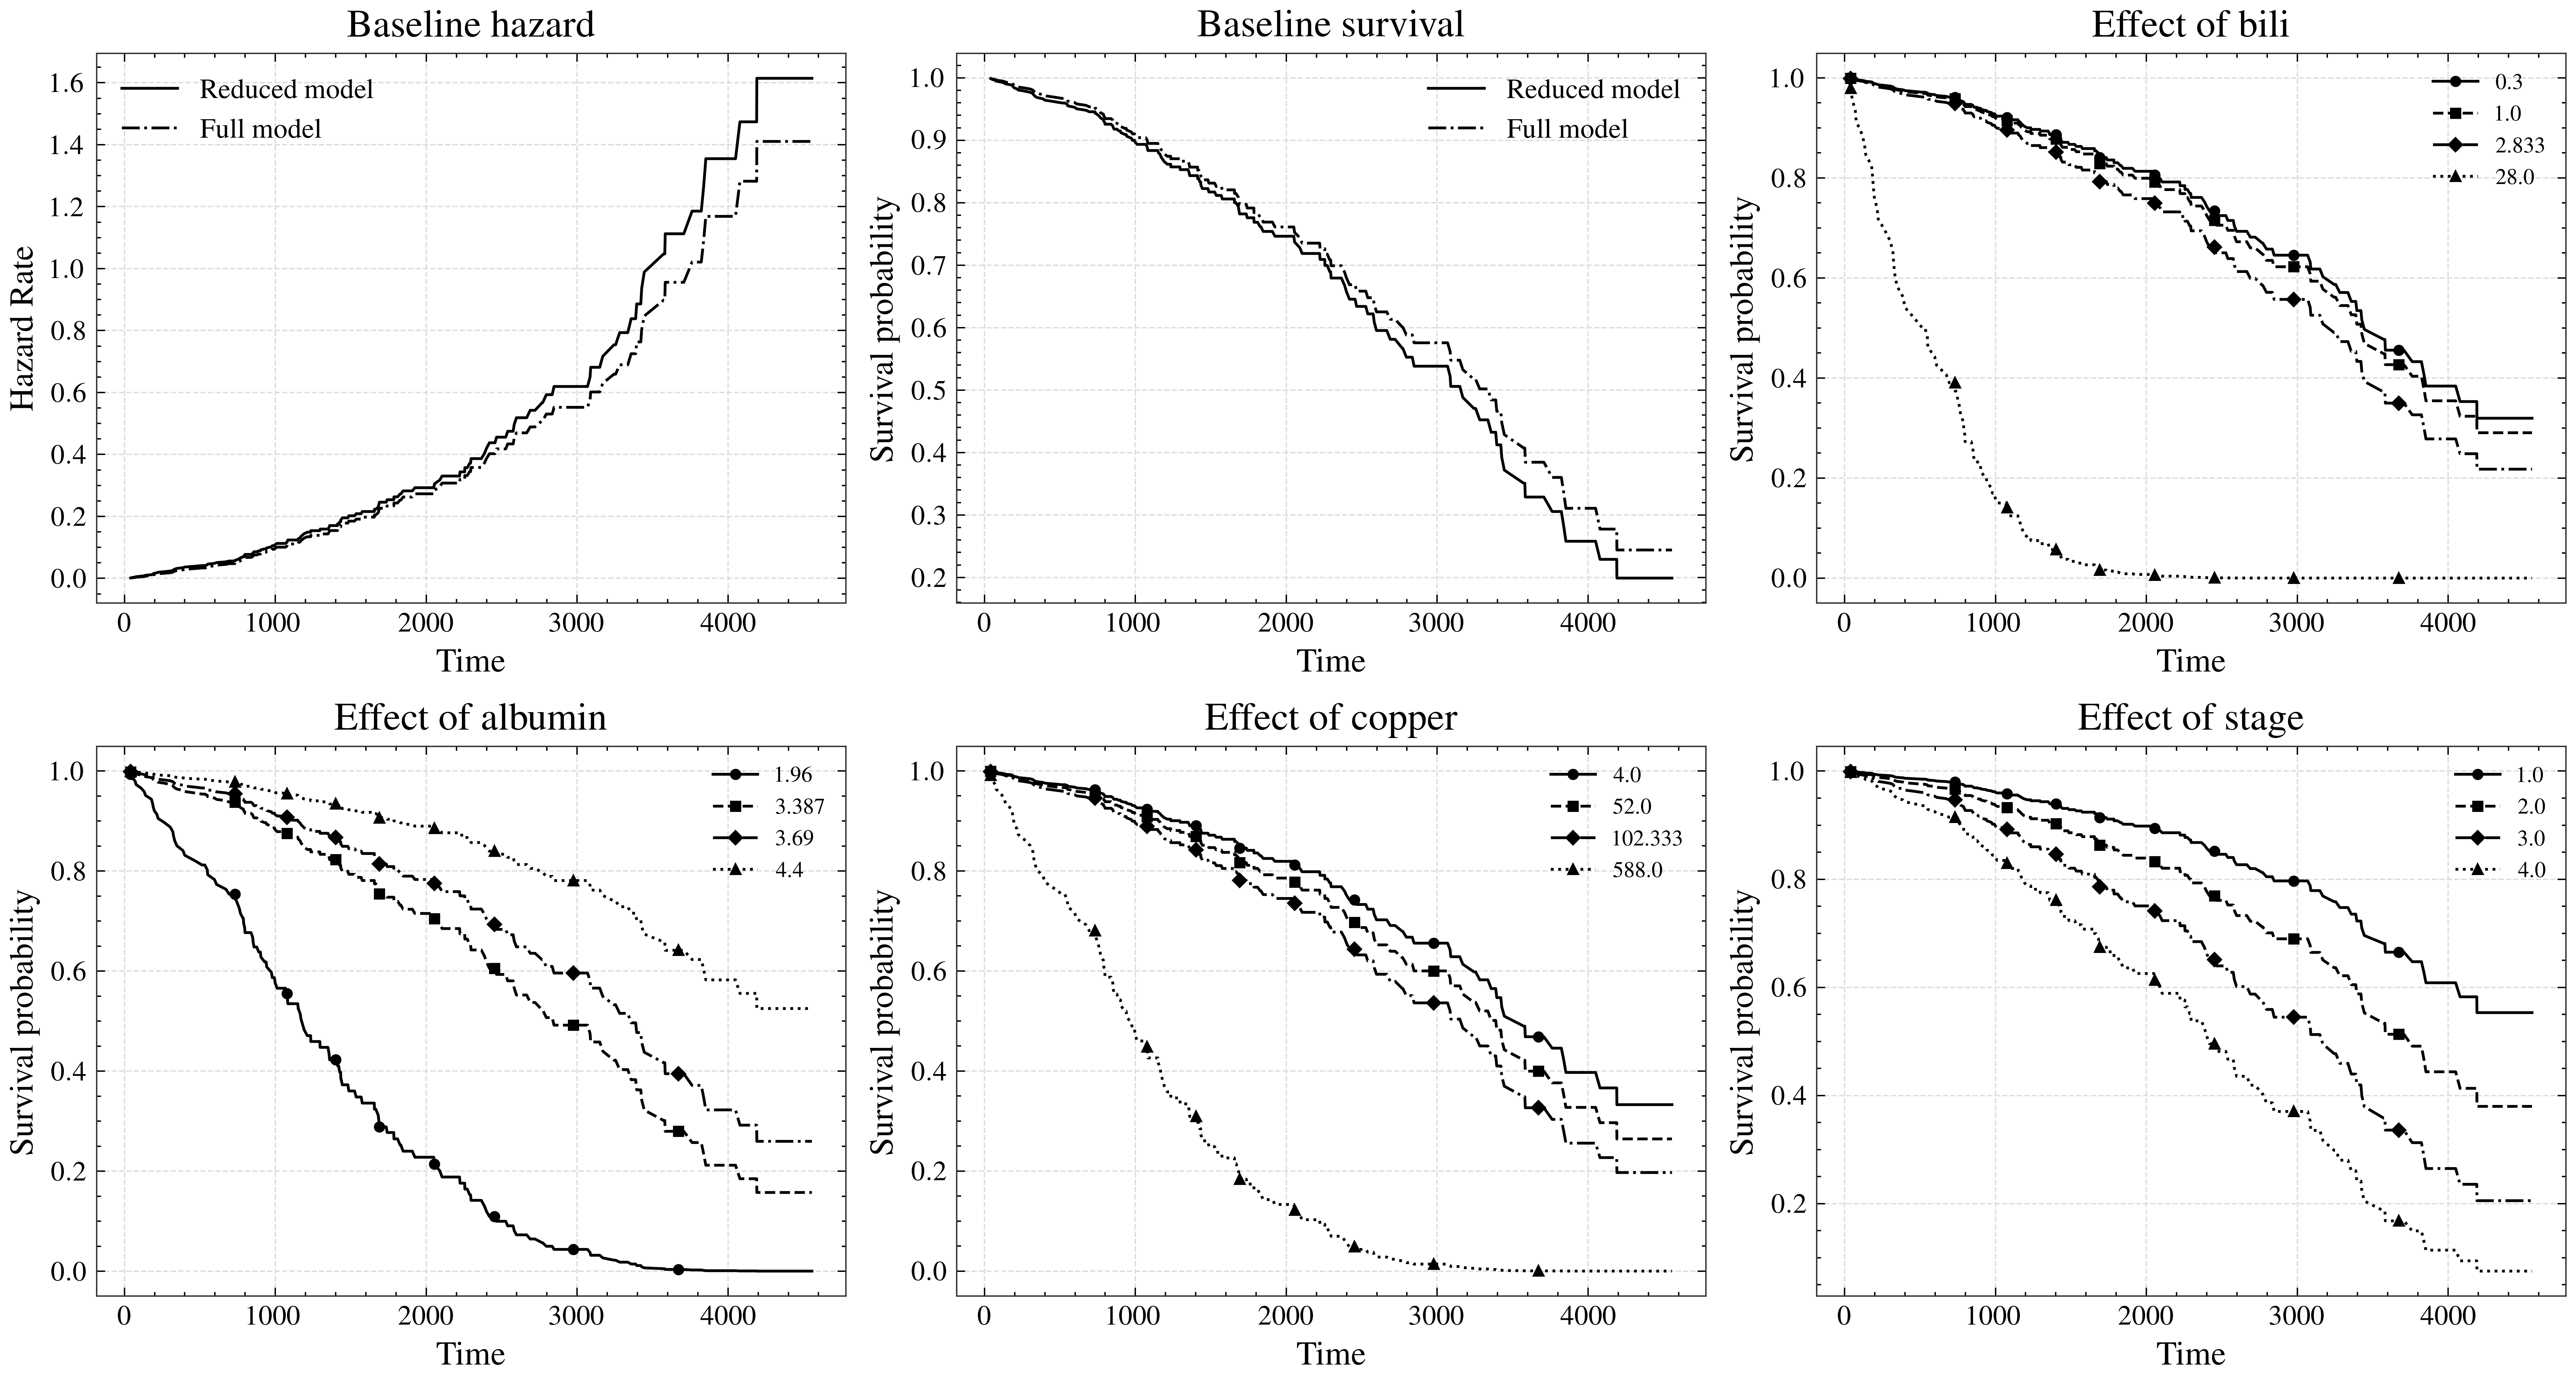

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(13, 7))  # bigger figsize to fit 6 plots
axes = ax.ravel()  # flatten 2x3 -> 1D array of length 6

# first two plots
axes[0].plot(model.baseline_hazard_, label='Reduced model')
axes[0].plot(model_full.baseline_hazard_, linestyle='-.', label='Full model', color='black')
axes[0].set_title("Baseline hazard")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Hazard Rate")
axes[0].legend()
axes[1].plot(model.baseline_survival_, label='Reduced model')
axes[1].plot(model_full.baseline_survival_, linestyle='-.', label='Full model', color='black')
axes[1].set_title("Baseline survival")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Survival probability")
axes[1].legend()

# remaining subplots for features
for feat_name, axi in zip(model.selected_features_, axes[2:]):
    feature_effect(X, feat_name, model, ax=axi)
    axi.set_title(f"Effect of {feat_name}")
    axi.set_xlabel("Time")
    axi.set_ylabel("Survival probability")

plt.tight_layout()
plt.savefig('pbc_feature_effects.pdf', dpi=500)
plt.show()

### Multiple runs results

In [23]:
METHODS = [
    'HarderLASSO_QUT', 'LASSO_QUT',
    'LASSO_CV', 'AIC', 'BIC'
]

In [24]:
def parse_features(feature_string):
    """Parse comma-separated feature string into list of integers."""
    if pd.isna(feature_string) or feature_string == '':
        return []
    return [int(float(x.strip())) for x in str(feature_string).split(',')]

# Parse selected features for each method
results_df = pd.read_csv('results.csv')
print("Parsing selected features...")
for method in METHODS:
    feature_col = f'{method}_features'
    if feature_col in results_df.columns:
        results_df[f'{method}_features'] = results_df[feature_col].apply(parse_features)
        print(f"✓ {method}")

# Load data
print(f"Loaded {len(results_df)} result rows")

Parsing selected features...
✓ HarderLASSO_QUT
✓ LASSO_QUT
✓ LASSO_CV
✓ AIC
✓ BIC
Loaded 100 result rows


In [25]:
import pandas as pd
from collections import Counter
import itertools

mean_cindex = {m: results_df[f"{m}_c_index"].mean() for m in METHODS}

# ---- Step 3: feature selection counts per method ----
feature_counts = {}
for m in METHODS:
    all_feats = results_df[f"{m}_features"].tolist()
    all_feats = list(itertools.chain.from_iterable(all_feats))

    # Flatten and count
    counts = Counter(all_feats)
    feature_counts[m] = counts

# ---- Step 4: expand counts into DataFrame ----
# Get union of all features across methods
all_features = sorted(set(f for counts in feature_counts.values() for f in counts))

feature_names = list(X.columns)

# ---- Build final summary with real names ----
summary_rows = []
for m in METHODS:
    row = {"method": m, "mean_c_index": mean_cindex[m]}
    for f in all_features:
        col_name = feature_names[f]   # map index to name
        row[col_name] = feature_counts[m].get(f, 0)
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).set_index("method")
summary_df

,mean_c_index,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
method,,,,,,,,,,,,,,,,,,
HarderLASSO_QUT,0.815473,0,45,4,22,1,4,62,100,0,77,86,1,5,0,0,38,81
LASSO_QUT,0.827187,0,64,3,61,15,11,91,100,0,95,100,1,13,0,0,74,98
LASSO_CV,0.828784,21,86,41,62,32,39,90,100,36,97,100,27,69,33,17,89,96
AIC,0.820877,9,73,29,19,5,10,68,100,22,85,85,9,66,19,7,66,92
BIC,0.814002,0,60,9,14,2,3,44,100,1,70,75,2,24,4,2,31,86
